# 3.6.2 Simple Linear Regression

The MASS library contains the Boston data set, which records medv (median house value) for 506 neighborhoods around Boston. We will seek to predict medv using 13 predictors such as rm (average number of rooms per house), age (average age of houses), and lstat (percent of households with low socioeconomic status).

In [126]:
# %load ../dss_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

## Load Dataset

In [127]:
boston = pd.read_csv('Data/Boston.csv', usecols=list(range(1, 15)))
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


### Least squares fit with lstat as the predictor

We will start by fitting a simple linear regression (OLS - for "ordinary least squares" method) with medv as the response and lstat as the predictor.

In [128]:
lm = sm.OLS.from_formula('medv ~ lstat', boston)
lm_fit = lm.fit()

### Detailed information about the model

In [129]:
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           5.08e-88
Time:                        20:53:34   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

In [131]:
lm_fit.summary().tables[0]

Dep. Variable:,medv,R-squared:,0.544
Model:,OLS,Adj. R-squared:,0.543
Method:,Least Squares,F-statistic:,601.6
Date:,"Mon, 10 Apr 2017",Prob (F-statistic):,5.08e-88
Time:,20:53:35,Log-Likelihood:,-1641.5
No. Observations:,506,AIC:,3287.
Df Residuals:,504,BIC:,3295.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [132]:
lm_fit.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,34.5538,0.563,61.415,0.000,33.448 35.659
lstat,-0.9500,0.039,-24.528,0.000,-1.026 -0.874


In [133]:
lm_fit.summary().tables[2]

Omnibus:,137.043,Durbin-Watson:,0.892
Prob(Omnibus):,0.000,Jarque-Bera (JB):,291.373
Skew:,1.453,Prob(JB):,5.36e-64
Kurtosis:,5.319,Cond. No.,29.7


### Predictions using the model

The predict() function can be used to produce confidence intervals and prediction intervals for the prediction of medv for a given value of lstat

First, we'll set up a dataframe containing the lstat values for which we want to predict a response:

In [134]:
lstatValues = pd.DataFrame([[1, 5], [1, 10], [1, 15]], columns=['Intercept', 'lstat'])

In [135]:
# Get the predicted values with confidence interval
def predict_confidence(fit, values):
    
    # Get the predicted values
    p = pd.DataFrame(fit.predict(values), columns=['fit'])
    
    # Get the confidence interval for the model (and rename the columns to something a bit more useful)
    ci = fit.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # Get the confidence intervals for the predictions
    ci = ci.T.dot(values.T).T
    
    # Wrap up the confidence intervals with the predicted values
    return pd.concat([p, ci], axis=1)

In [136]:
predict_confidence(lm_fit, lstatValues)

         fit      lower      upper
0  29.803594  28.317716  31.289472
1  25.053347  23.186975  26.919720
2  20.303101  18.056234  22.549967

For instance, the 95 % confidence interval associated with a lstat value of 10 is (23.19, 26.92).

### Plot of the least squares regression line

We will now plot medv and lstat along with the least squares regression line using the Seaborn Python visualization library

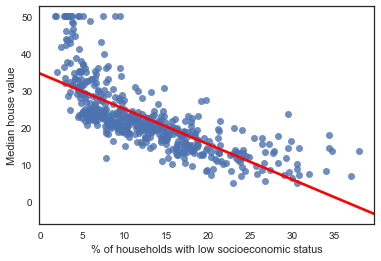

In [139]:
sns.regplot('lstat', 'medv', boston, line_kws={"color": "r"}, ci=None)

plt.xlabel('% of households with low socioeconomic status')
plt.ylabel('Median house value');

There is some evidence for non-linearity in the relationship between lstat and medv. We will explore this issue later in this lab.

### Diagnostic plots

Next we examine some diagnostic plots, several of which were discussed in Section 3.3.3. 

We can compute and plot the residuals from the least squares regression line using the regplot() function. 

The residuals are found in the static '.resid'.

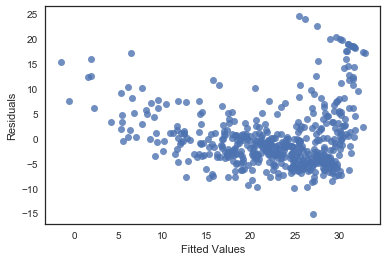

In [141]:
fitted_values = pd.Series(lm_fit.fittedvalues, name="Fitted Values")
residuals = pd.Series(lm_fit.resid, name="Residuals")
sns.regplot(fitted_values, residuals, fit_reg=False);

We can compute and plot the studentized residuals from the least squares regression line using the regplot() function. 

The studentized residuals are found in the static .resid_pearson

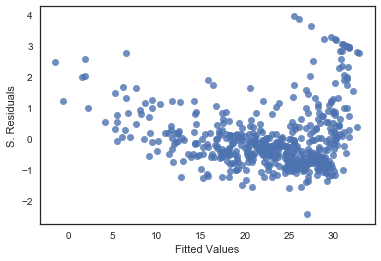

In [144]:
s_residuals = pd.Series(lm_fit.resid_pearson, name="S. Residuals")
sns.regplot(fitted_values, s_residuals,  fit_reg=False);

On the basis of the residual plots, there is some evidence of non-linearity. Leverage statistics can be computed using the OLSInfluence().influence method.

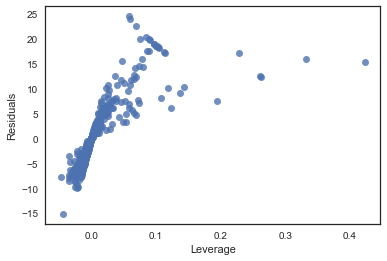

In [145]:
leverage = pd.Series(OLSInfluence(lm_fit).influence, name="Leverage")
sns.regplot(leverage, residuals,  fit_reg=False);